# Method of Multipliers

##### Contents

1.  [Quick Overview of Method of Multipliers](#Overview) <br>
2.  [Application of Method of Multipliers](#Application) <br>

More details on section _2.  Application of Method of Multipliers_:
1. [Update Rules](#Update_Rules) <br>
2. [Code](#Code) <br>
    2.1. [Helper Functions](#Helper_Functions) <br>
    2.2. [Main Method of Multipliers Function](#MM_Function) <br>
    2.3. [Running Method of Multipliers](#Running_MM) <br>


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import Image

<br/>

### 1.  <a id = 'Overview'> Quick Overview of Method of Multipliers </a>

Let us consider an optimization problem with *equality constraints*:
\begin{align*}
    \min_{x \in \mathbb{R}^d} \ &\ \ f(x)   \\
    \text{subject to} \ &\ \ Ax = b
\end{align*}
where $A$ is some $m \times d$ matrix.

Let $y \in \mathbb{R}^m$ and $\rho \in \mathbb{R}$ be the *penalty paramenter*, it follows that the *augmented* Lagrangian and its dual function are
\begin{align*}
    L_{\rho}(x,y) \ &= \ f(x) + y^T(Ax-b) + \frac{1}{2} \left( \rho\|Ax-b\|^2 \right)  \\
    \hat{f} \ &= \ \inf_{x \in \mathbb{R}^d} L_{\rho}(x,y)
        \ = \ \inf_{x \in \mathbb{R}^d}  \left( f(x) + y^T(Ax-b) + \frac{1}{2} \left( \rho\|Ax-b\|^2 \right) \right)
\end{align*}

The __method of multipliers__ algorithm is thus:

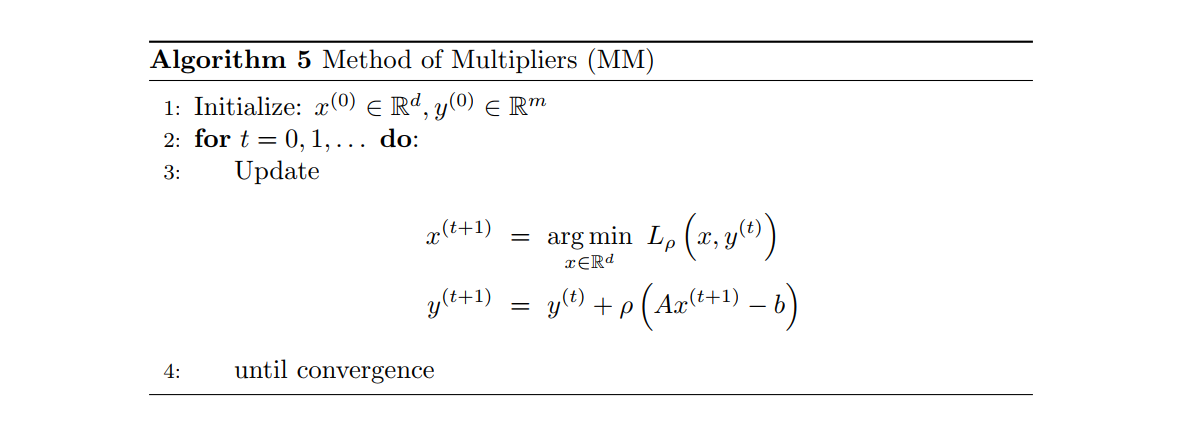

In [2]:
Image(filename = "Algorithm Summary/Method of Multipliers.png", width=600, height=400)

More information on the **method of multipliers** algorithm as well as its variants are summarized in the [Optimization - Algorithm Summary](https://github.com/thn003/optimization_num_analysis/blob/master/Optimization/Optimzation%20-%20Algorithm%20Summary.pdf).

***

<br/>

### 2.  <a id = 'Application'> Application of Method of Multipliers </a>

In this project, we will

1.  Write a generic function to run *method of multipliers* </br>
2.  Apply the function on $f(x) = x^T x$, $A$ is a $500 \times 1000$ matrix of standard gaussian entries, and $b = \mathbb{1}$, which is the same problem we used in applying the __[dual ascent](https://nbviewer.jupyter.org/github/thn003/NumAnalysis_Optimization/blob/master/Optimization/Dual%20Ascent.ipynb)__ algorithm
    
</br>

#### 2.1.  <a id = 'Update_Rules'> Update Rules </a>

From $f(x) = x^T x$, the augmented Lagrangian is:
$$
    L_{\rho}(x, y) \ = \ x^Tx + y^T (Ax - b) + \frac{1}{2} \left( \rho \|Ax - b\|^2 \right)
$$

The dual function is $\hat{f} = \inf_x L_{\rho}(x,y)$. The $y$-update, which is the gradient of $\hat{f}$ with respect to $y$, is:
$$
    \nabla_y \hat{f}(y) = Ax - b
$$

Taking the gradient of $L_{\rho}$ with respect to $x$ and setting that to $0$ gives the $x$-update:
$$
    \nabla_x L_{\rho}(x,y) = 2x + A^T y + \rho A^T (Ax - b)
    \ \ \ \implies \ x = \left( 2I_n + A^T A \right)^{-1} \left( \rho A^T b - A^T y \right)
$$

Putting these together, the update rules are:
\begin{align*}
    x^{(t+1)} \ &= \ \left( 2I_n + A^T A \right)^{-1} \left( \rho A^T b - A^T y \right)    \\
    y^{(t+1)} \ &= \ y^{(t)} + \rho \left( Ax^{(t)} - b \right)   \\
\end{align*}

</br>


#### 2.2.  <a id = 'Code'> Code </a>

##### 2.2.1.  <a id = 'Helper_Functions'> Helper Functions </a>

We first define some helper functions to compute the functions and their gradients:

*  `f` for computing $f(x) = x^T x$
*  `cond` for the solution feasibility $\|Ax - b\|$
*  `plot` for plotting results

In [3]:
def f(x):
    return np.dot(x,x)

def cond(x):
    return np.linalg.norm( np.dot(A,x) - b, 2)

def plot(values, labels, colors, title, ylabel):
    k = len(labels)
    plt.box(False)
    for i in range(0,k):
        plt.plot(idx, values[i], '-', color = colors[i], alpha=.75, linewidth = 2, label = labels[i])
    plt.title(title, fontsize = 15)
    plt.ylabel(ylabel, fontsize = 12)
    plt.legend()

<br/>

##### 2.2.2.  <a id = 'MM_Function'> Main Method of Multipliers Function </a>

In [4]:
def method_multipliers( x, y, rho, T ):
    
    # Vector to store (1) loss value, (2) condition feasibility
    loss_vector, cond_vector = np.zeros(T), np.zeros(T)
    
    # Compute some constants in the x-update
    term1 = np.linalg.inv( np.identity(d) + rho * np.dot(A.transpose(), A) )
    term2 = rho * np.dot(A.transpose(), b)

    for t in range(0, T):       
        
        # Update x
        x = - np.dot( A.transpose(), y ) / 2
        x = np.dot( term1 , (term2 - np.dot(A.transpose(), y)) )
        # Update y
        y = y + rho * ( np.dot(A,x) - b )
        
        # Update loss and feasibility
        loss_vector[t] = f(x)
        cond_vector[t] = cond(x)
        
    return loss_vector, cond_vector

<br/>

##### 2.2.3.  <a id = 'Running_MM'> Running Method of Multipliers </a>

Since $A$ is random with fixed dimension, $b$ is fixed, it remains that the step size $\rho$ is uncontrolled. We will thus play around with $\rho$: running over different choices of $\rho$ and observe the associated convergence rates.

In particular, we will run over these choices of $\rho_t$:
$$
    \rho \ \in \ \left\{ .001, .005, .01, .05 \right\}
$$
and fix $x = \mathbb{0}$, and $y$ is uniformly random in $[0,1]$.

In [5]:
# Problem parameters
m, d = 500, 1000
np.random.seed(173)
A = np.round(np.random.normal(0,1,m*d),3).reshape(m,d)
b = np.ones(m)

# Algorithm parameters
x = np.zeros(d)
y = np.random.rand(m)

Running the algorithm

In [6]:
rhos = [.001, .005, .01, .05]
T = 400

# Initialize arrays to store losses and feasibility
MM_Loss, MM_Cond = list(), list()

# Run the model
for i in range(0, len(rhos)):
    loss_tmp, cond_tmp = method_multipliers( x, y, rhos[i], T )
    MM_Loss.append(loss_tmp)
    MM_Cond.append(cond_tmp)

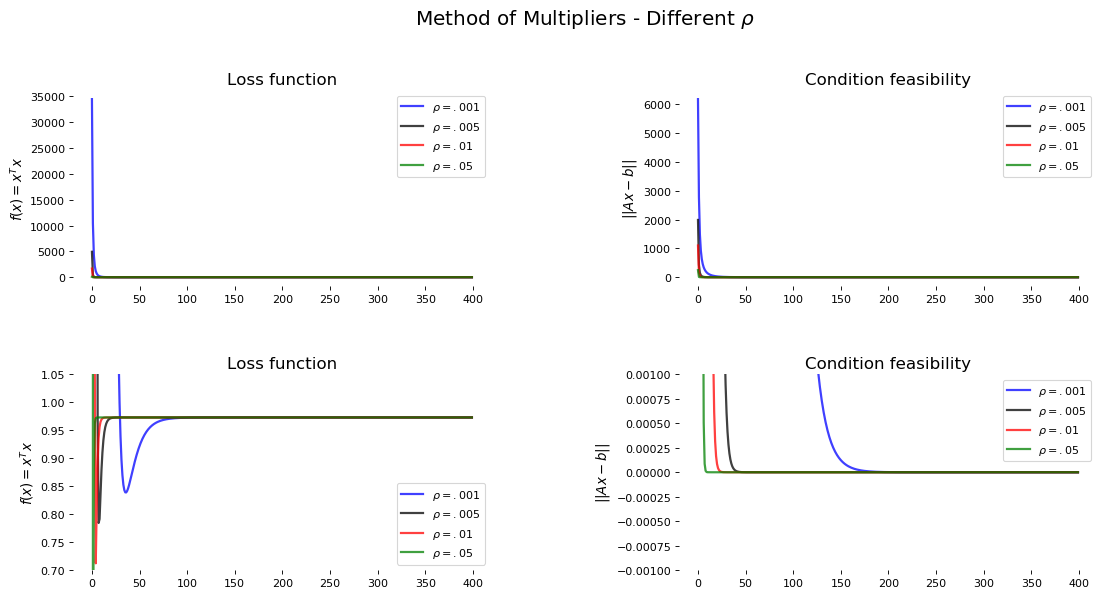

In [7]:
figure(num=None, figsize=(16, 8), dpi=80, facecolor='w')

labels = [r'$\rho = .001$', r'$\rho = .005$', r'$\rho = .01$', r'$\rho = .05$']
colors = ['blue', 'black', 'red', 'green']
idx = np.arange(0, T)

plt.subplot(2, 2, 1)
plot(MM_Loss, labels, colors, 'Loss function', '$f(x) = x^T x$')

plt.subplot(2, 2, 2)
plot(MM_Cond, labels, colors, 'Condition feasibility', '$||Ax - b||$')

plt.subplot(2, 2, 3)
plt.ylim(.7, 1.05)
plot(MM_Loss, labels, colors, 'Loss function', '$f(x) = x^T x$')

plt.subplot(2, 2, 4)
plt.ylim(-.001, .001)
plot(MM_Cond, labels, colors, 'Condition feasibility', '$||Ax - b||$')

# Common title
plt.suptitle('Method of Multipliers - Different ' + r'$\rho$', fontsize = 18)
plt.tight_layout()
plt.subplots_adjust(.1, .1, .9, .85, .45, .45)